## Import Data ##

In [1]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.offline as pyo
import pandas as pd
import numpy as np
import networkx as nx
import random
from scipy.stats import *
import time
import warnings
import os

warnings.filterwarnings("ignore", category=DeprecationWarning)

device = "mps" if torch.mps.is_available() else "cpu"
print(device)

mps


In [3]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root="/tmp/CiteSeer", name="CiteSeer")
data = dataset[0]

## Statistical Modeling ##

In [5]:
pd_data = pd.DataFrame(data.x.cpu().numpy())

In [7]:
pd_data.shape

(3327, 3703)

In [11]:
pd_data.corr()

,0,1,2,3,4,5,6,7,8,9,...,3693,3694,3695,3696,3697,3698,3699,3700,3701,3702
0,1.000000,-0.011353,-0.004619,-0.004964,-0.003387,-0.003621,-0.004050,-0.003841,-0.004248,-0.004437,...,-0.007714,-0.003387,0.102914,-0.002861,-0.002559,-0.003387,-0.002559,-0.002861,-0.002861,-0.002861
1,-0.011353,1.000000,-0.009640,-0.010359,0.036558,-0.007557,-0.008451,-0.008017,-0.008865,-0.009261,...,-0.016099,-0.007068,-0.005972,-0.005972,-0.005340,-0.007068,-0.005340,-0.005972,-0.005972,-0.005972
2,-0.004619,-0.009640,1.000000,-0.004215,-0.002876,-0.003075,-0.003439,-0.003262,-0.003607,-0.003768,...,-0.006551,-0.002876,-0.002430,-0.002430,-0.002173,-0.002876,-0.002173,-0.002430,-0.002430,-0.002430
3,-0.004964,-0.010359,-0.004215,1.000000,-0.003090,-0.003304,-0.003695,-0.003505,-0.003876,-0.004049,...,-0.007039,-0.003090,-0.002611,-0.002611,-0.002335,-0.003090,-0.002335,-0.002611,-0.002611,-0.002611
4,-0.003387,0.036558,-0.002876,-0.003090,1.000000,-0.002254,-0.002521,-0.002391,-0.002645,-0.002763,...,0.058602,-0.002108,-0.001781,-0.001781,-0.001593,-0.002108,-0.001593,-0.001781,-0.001781,-0.001781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3698,-0.003387,-0.007068,-0.002876,-0.003090,-0.002108,-0.002254,-0.002521,-0.002391,-0.002645,-0.002763,...,-0.004802,-0.002108,-0.001781,-0.001781,-0.001593,1.000000,-0.001593,-0.001781,-0.001781,-0.001781
3699,-0.002559,-0.005340,-0.002173,-0.002335,-0.001593,-0.001703,-0.001905,-0.001807,-0.001998,-0.002087,...,-0.003629,-0.001593,-0.001346,-0.001346,-0.001204,-0.001593,1.000000,-0.001346,-0.001346,-0.001346
3700,-0.002861,-0.005972,-0.002430,-0.002611,-0.001781,-0.001905,-0.002130,-0.002021,-0.002234,-0.002334,...,-0.004058,-0.001781,-0.001505,-0.001505,-0.001346,-0.001781,-0.001346,1.000000,-0.001505,-0.001505
3701,-0.002861,-0.005972,-0.002430,-0.002611,-0.001781,-0.001905,-0.002130,-0.002021,-0.002234,-0.002334,...,-0.004058,-0.001781,-0.001505,-0.001505,-0.001346,-0.001781,-0.001346,-0.001505,1.000000,-0.001505


In [12]:
pd_data.describe()

,0,1,2,3,4,5,6,7,8,9,...,3693,3694,3695,3696,3697,3698,3699,3700,3701,3702
count,3327.000000,3327.000000,3327.000000,3327.000000,3327.000000,3327.000000,3327.000000,3327.000000,3327.000000,3327.000000,...,3327.000000,3327.000000,3327.000000,3327.000000,3327.000000,3327.000000,3327.000000,3327.000000,3327.000000,3327.000000
mean,0.005410,0.023144,0.003907,0.004509,0.002104,0.002405,0.003006,0.002705,0.003306,0.003607,...,0.010821,0.002104,0.001503,0.001503,0.001202,0.002104,0.001202,0.001503,0.001503,0.001503
std,0.073366,0.150381,0.062396,0.067003,0.045828,0.048985,0.054749,0.051948,0.057413,0.059958,...,0.103472,0.045827,0.038743,0.038743,0.034658,0.045827,0.034658,0.038743,0.038743,0.038743
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [130]:
def data_to_nx_subgraph(data, node_range):
    G = nx.Graph()

    selected_nodes = list(node_range)

    G.add_nodes_from(selected_nodes)

    edge_index = data.edge_index
    edges = edge_index.t().tolist()
    
    filtered_edges = [(u, v) for u, v in edges if u in selected_nodes and v in selected_nodes]
    
    G.add_edges_from(filtered_edges)

    return G

node_range = range(0, 500)

G = data_to_nx_subgraph(data, node_range)

In [132]:
nx.cluster.average_clustering(G)

0.004666666666666667

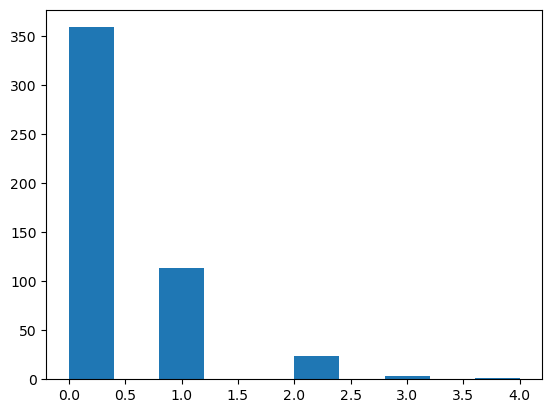

In [134]:
plt.hist([v for k, v in nx.degree(G)]);

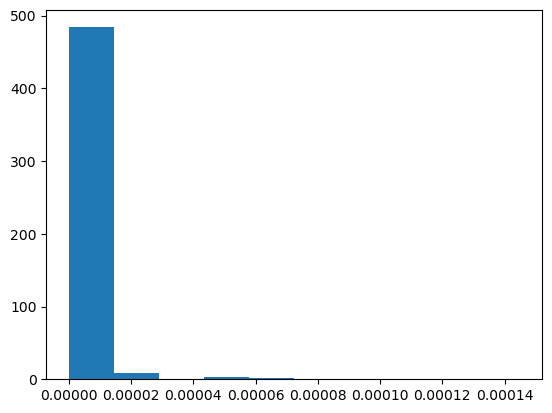

In [136]:
plt.hist(nx.centrality.betweenness_centrality(G).values());

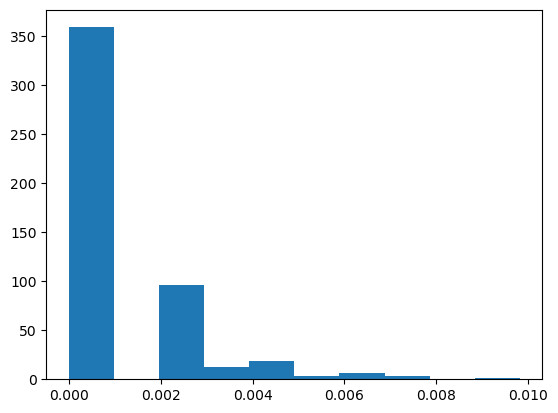

In [138]:
plt.hist(nx.centrality.closeness_centrality(G).values());

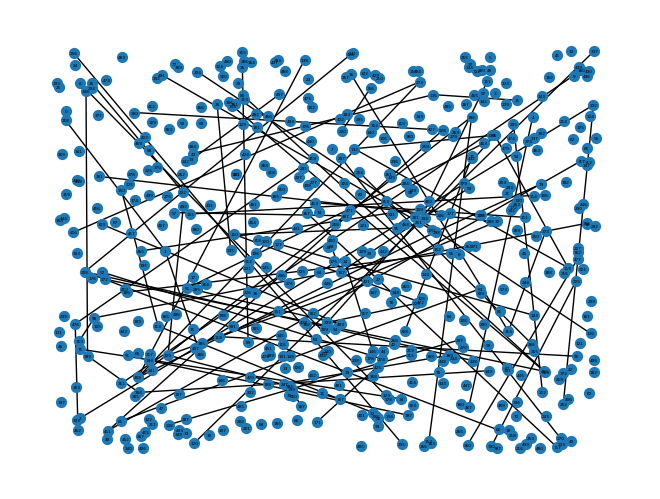

In [140]:
nx.draw_random(G, with_labels=True, node_size=50, font_size=3)
plt.show()

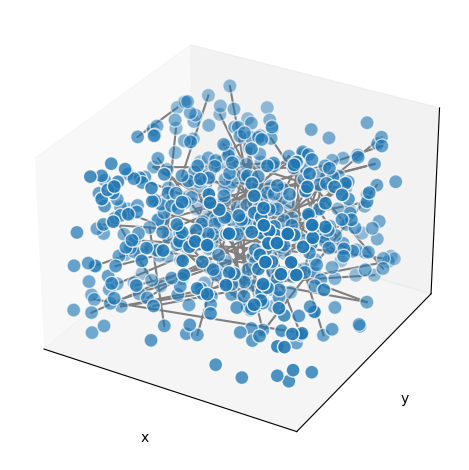

In [164]:
from mpl_toolkits.mplot3d import Axes3D

pos = nx.random_layout(G, dim=3, seed=779)

node_xyz = np.array([pos[v] for v in sorted(G)])
edge_xyz = np.array([(pos[u], pos[v]) for u, v in G.edges()])

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

ax.scatter(*node_xyz.T, s=100, ec="w")

for vizedge in edge_xyz:
    ax.plot(*vizedge.T, color="tab:gray")


def _format_axes(ax):
    ax.grid(False)

    for dim in (ax.xaxis, ax.yaxis, ax.zaxis):
        dim.set_ticks([])

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")


_format_axes(ax)
fig.tight_layout()
plt.show()

## Training Model ##

In [377]:
class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        
        return x

In [404]:
LR = 1e-04
HIDDEN = 100
EPOCHS = 500

In [406]:
model = GCN(in_channels=dataset.num_node_features, hidden_channels=HIDDEN, out_channels=dataset.num_classes)
optimizer = Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

In [408]:
summary(model)

Layer (type:depth-idx)                   Param #
GCN                                      --
├─GCNConv: 1-1                           100
│    └─SumAggregation: 2-1               --
│    └─Linear: 2-2                       370,300
├─GCNConv: 1-2                           100
│    └─SumAggregation: 2-3               --
│    └─Linear: 2-4                       10,000
Total params: 380,500
Trainable params: 380,500
Non-trainable params: 0

In [410]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        test_accuracy = (pred[data.test_mask] == data.y[data.test_mask]).sum() / data.test_mask.sum()
        return test_accuracy.item()

In [412]:
start_time = time.time()

for epoch in range(EPOCHS):
    loss = train()
    if epoch % 10 == 0:
        test_acc = test()
        print(f'Epoch: {epoch}, Loss: {loss:.4f}, Test Accuracy: {test_acc:.4f}')

print("\nTraining Time is: ", round((time.time() - start_time), 4), " Seconds")

Epoch: 0, Loss: 4.6198, Test Accuracy: 0.0000
Epoch: 10, Loss: 4.5829, Test Accuracy: 0.0210
Epoch: 20, Loss: 4.5273, Test Accuracy: 0.1670
Epoch: 30, Loss: 4.4614, Test Accuracy: 0.2580
Epoch: 40, Loss: 4.3826, Test Accuracy: 0.3310
Epoch: 50, Loss: 4.2865, Test Accuracy: 0.3530
Epoch: 60, Loss: 4.1764, Test Accuracy: 0.3770
Epoch: 70, Loss: 4.0549, Test Accuracy: 0.4050
Epoch: 80, Loss: 3.9243, Test Accuracy: 0.4300
Epoch: 90, Loss: 3.7849, Test Accuracy: 0.4640
Epoch: 100, Loss: 3.6383, Test Accuracy: 0.4780
Epoch: 110, Loss: 3.4856, Test Accuracy: 0.4920
Epoch: 120, Loss: 3.3273, Test Accuracy: 0.5090
Epoch: 130, Loss: 3.1644, Test Accuracy: 0.5160
Epoch: 140, Loss: 2.9977, Test Accuracy: 0.5270
Epoch: 150, Loss: 2.8286, Test Accuracy: 0.5330
Epoch: 160, Loss: 2.6584, Test Accuracy: 0.5420
Epoch: 170, Loss: 2.4887, Test Accuracy: 0.5480
Epoch: 180, Loss: 2.3207, Test Accuracy: 0.5590
Epoch: 190, Loss: 2.1562, Test Accuracy: 0.5690
Epoch: 200, Loss: 1.9962, Test Accuracy: 0.5770
Epo

## Post-Training Analysis ##

In [414]:
embeddings = []

def hook(module, input, output):
    embeddings.append(output.detach().cpu())

model.conv2.register_forward_hook(hook)

model.eval()
out = model(data.x, data.edge_index)

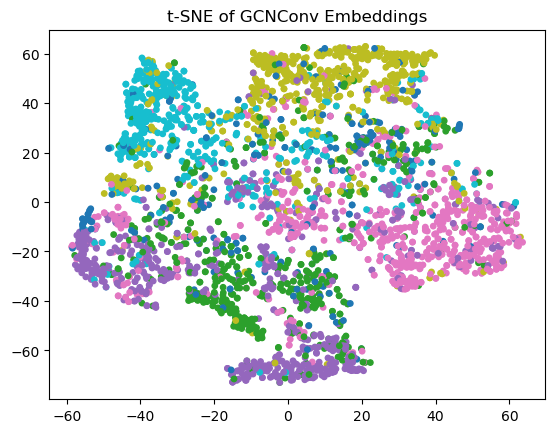

In [431]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

z = TSNE(n_components=2).fit_transform(embeddings[0].numpy())
plt.scatter(z[:, 0], z[:, 1], c=data.y.cpu(), cmap="tab10", s=15)
plt.title("t-SNE of GCNConv Embeddings")
plt.show()

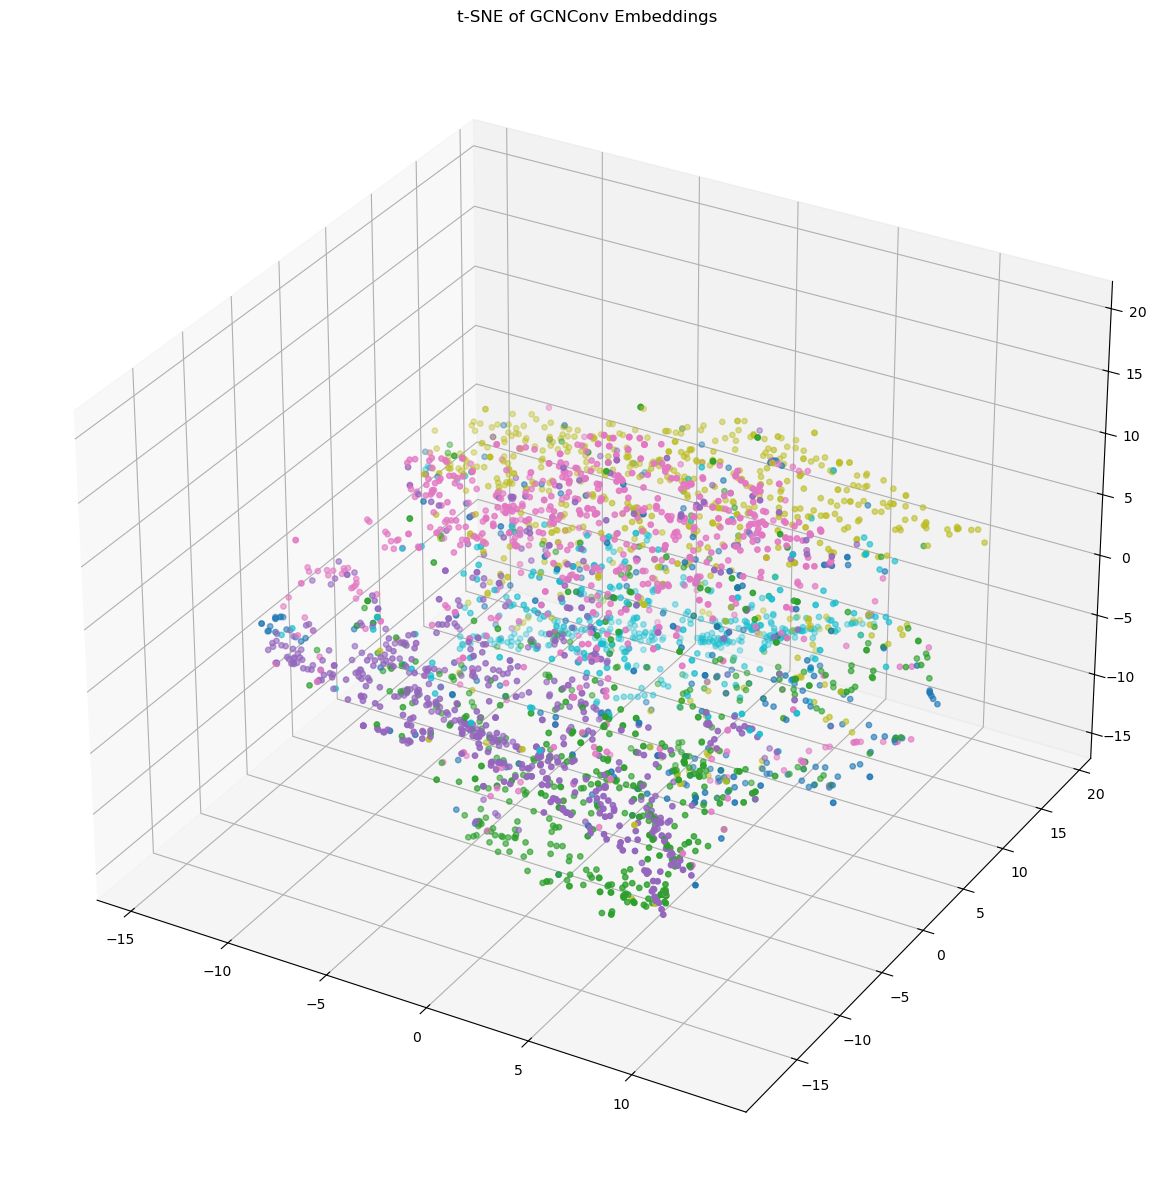

In [450]:
z = TSNE(n_components=3).fit_transform(embeddings[0].numpy())

fig = plt.figure(figsize = (15, 15))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(z[:, 0], z[:, 1], z[:, 2], c=data.y.cpu(), cmap="tab10", s=15)
plt.title("t-SNE of GCNConv Embeddings")
plt.show()

In [417]:
probs = F.softmax(out, dim=1)
confidence, pred_class = probs.max(dim=1)

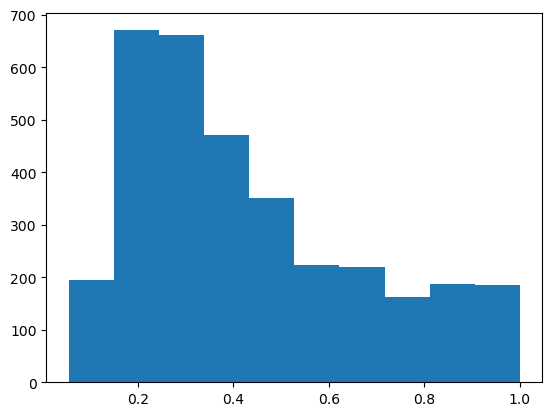

In [418]:
plt.hist(confidence.detach().numpy())
plt.show()

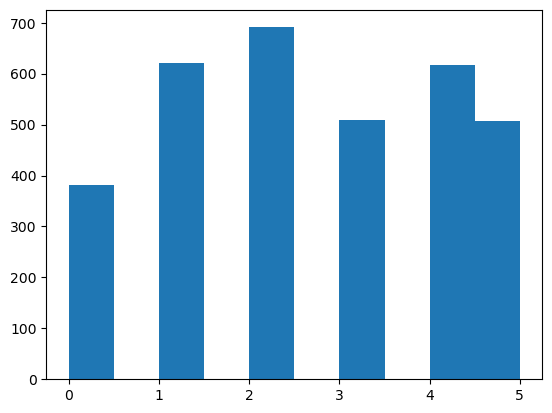

In [419]:
plt.hist(pred_class)
plt.show()

In [420]:
wrong = (pred_class != data.y).cpu()
wrong_nodes = torch.nonzero(wrong).flatten()

print(f"Number of Misclassified Nodes: {len(wrong_nodes.tolist())}")

Number of Misclassified Nodes: 1157


In [422]:
torch.save(model.state_dict(), "CiteSeer.pth")

In [428]:
loaded_model = GCN(in_channels=dataset.num_node_features, hidden_channels=HIDDEN, out_channels=dataset.num_classes).to(device)
loaded_model.load_state_dict(torch.load("CiteSeer.pth"))
loaded_model.eval()

GCN(
  (conv1): GCNConv(3703, 100)
  (conv2): GCNConv(100, 100)
)